# Volatility Breakout Strategy

In [1]:
import logging, os, pickle
import requests, glob
from datetime import datetime
import pandas as pd
import time
from datetime import date
import json, re, sys, h5py
import datetime as dt
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings(action='ignore')
import shutil
from matplotlib.pyplot import cm
import numpy as np
import scipy.stats as stats
from scipy import stats
from statsmodels.tsa.stattools import coint, adfuller
from sklearn.linear_model import LinearRegression
import sys
import seaborn as sns
sys.path.append('C:\\Users\Bae Kyungmo\OneDrive\Desktop\StockTraidingAutomation\DataModeling')
from Loader_v2 import Loader
ldr = Loader(pwd='')

### Volatility Breakout process
* Range : high price - low price (yesterday)
* If mid price (= (high+low)/2) is higher than open price + range * k=0.5(param) then buy, and sell all before the market is closed.
* It means that it is not 'overnight trade'.
* K parameter could be optimized but usually 0.5 is preferred. And as you can easily understand lower k could be more tradable.
* I did some backtests about Volatility Breakout and found that too much trades are non-profitable(it means lower than bench mark return 0.02).
* So I added 'least' condition to make a trade started only when the expected return is over the bench mark (least) return.

In [2]:
def MDD(pr):
    code = pr.columns[0]
    x = pr[code]
    """
    MDD(Maximum Draw-Down)
    :return: (peak_upper, peak_lower, mdd rate)
    """
    arr_v = np.array(x)
    peak_lower = np.argmax(np.maximum.accumulate(arr_v) - arr_v)
    peak_upper = np.argmax(arr_v[:peak_lower])
    return round((arr_v[peak_lower] - arr_v[peak_upper]) / arr_v[peak_upper],2)

In [3]:
def SharpeRatio(rt_df, bncmrk=0.02):
    SR = np.sqrt(len(rt_df))*(rt_df['return'].mean() - bncmrk) / rt_df['return'].std()
    return SR

In [4]:
def SMA(pr, ndays=22, min_days=1):
    code = pr.columns[0]
    return pr[[code]].rolling(window=ndays, min_periods=min_days).mean()

In [5]:
def EMA(pr, ndays=22, min_days=1):
    code = pr.columns[0]
    return pr[[code]].ewm(ndays,min_periods=min_days).mean()

In [140]:
def VB_Signal(pr_df, k=0.5, least=0.02):
    pr = pr_df.copy()
    pr['mid'] = (pr['high']+pr['low'])/2
    pr['range'] = (pr['high'] - pr['low'])*k
    Buy=[]
    Sell=[]
    Buy.append(np.nan)
    Sell.append(np.nan)
    for i in range(len(pr)):
        if i != 0:
            if pr['mid'][i] > (pr['OPEN'][i] + pr['range'][i-1]):
                if (pr['close'][i] / pr['mid'][i] -1) >= least :
                    Buy.append(pr['mid'][i])
                    Sell.append(pr['close'][i])
                else :
                    Buy.append(np.nan)
                    Sell.append(np.nan)
            else :
                Buy.append(np.nan)
                Sell.append(np.nan)
    pr['BuySignal'] = Buy
    pr['SellSignal'] = Sell
    #pr['SellSignal']  = pr['SellSignal'].shift(1)
    return pr

In [144]:
def BackTest_v2(obv):
    tmp = obv[(~obv['BuySignal'].isnull())|(~obv['SellSignal'].isnull())]
    tmp['return'] = tmp['SellSignal'] / tmp['BuySignal']
    tmp['BuySignal'] = tmp['BuySignal'].fillna(0)
    tmp['SellSignal'] = tmp['SellSignal'].fillna(0)
    #tmp['return'] = tmp['series'].pct_change()+1
    tmp2 = tmp[tmp.SellSignal!=0.0]
    cm_rt = tmp2['return'].cumprod()[-1]
    hit_ratio = round(len(tmp2[tmp2['return']>=1]) / len(tmp2),2)
    best_rt = tmp2['return'].max()-1
    worst_rt = tmp2['return'].min()-1
    ar_mean = tmp2['return'].mean()
    gr_mean = np.exp(np.log(cm_rt)/len(tmp2))
    mdd = MDD(obv[['close']])
    SR = SharpeRatio(tmp2[['return']]-1)
    test_rst = pd.DataFrame(columns=['CumulativeReturn','HitRatio','BestReturn','WorstReturn','MDD','SimpleMean','GeoMean','#Trade'])
    test_rst.loc[0,'CumulativeReturn'] = round(cm_rt,2)
    test_rst.loc[0,'HitRatio'] = hit_ratio
    test_rst.loc[0,'BestReturn'] = round(best_rt,2)
    test_rst.loc[0,'WorstReturn'] = round(worst_rt,2)
    test_rst.loc[0,'SimpleMean'] = round(ar_mean,2)
    test_rst.loc[0,'GeoMean'] = round(gr_mean,2)
    test_rst.loc[0,'MDD'] = round(mdd*(-1),2)
    test_rst.loc[0,'SharpeRatio'] = round(SR,2)
    test_rst.loc[0,'#Trade'] = round(len(tmp2),2)
    return tmp2, test_rst

In [151]:
def VB_Run(start, end, code, k=0.5, least=0.02, doplot=True):
    pr = ldr.GetPricelv1(start, end, [code])
    pr = pr.rename(columns={'adjprice':'close'})
    pr.index = pr['DATE'].to_list()
    pr = pr.drop(['DATE','CODE'],axis=1)
    vb = VB_Signal(pr, k=k, least=least)
    
    if doplot :
        plt.style.use('fivethirtyeight')
        plt.figure(figsize=(10,8))
        p1 = plt.subplot(2,1,1)
        plt.title('Volatility BreakOut : {}'.format(code))
        plt.grid(True)
        plt.plot(vb.reset_index().index, vb['close'], color='c', label='Close')
        plt.plot(vb.reset_index().index, vb['mid'], color='black', label='MidPrice', alpha=0.35)
        plt.plot(vb.reset_index().index, vb['OPEN'] + vb['range'], color='navy', label='Signal')
        plt.xlabel('Date',fontsize=15)
        plt.ylabel('Close Price KRW',fontsize=15)
        plt.legend(loc='upper left')
        
        p2 = plt.subplot(2,1,2)
        plt.grid(True)
        plt.plot(vb.reset_index().index, vb['close'], color='m', label='Close',alpha=0.35)
        plt.scatter(vb.reset_index().index, vb['BuySignal'], color='green', label='BuySignal', marker='^', alpha=1)
        plt.scatter(vb.reset_index().index, vb['SellSignal'], color='red', label='SellSignal', marker='v', alpha=1)
        plt.legend(loc='upper left')
        
        plt.show()
        
    _, rst = BackTest_v2(vb)
    rst.index = [code]
    return rst

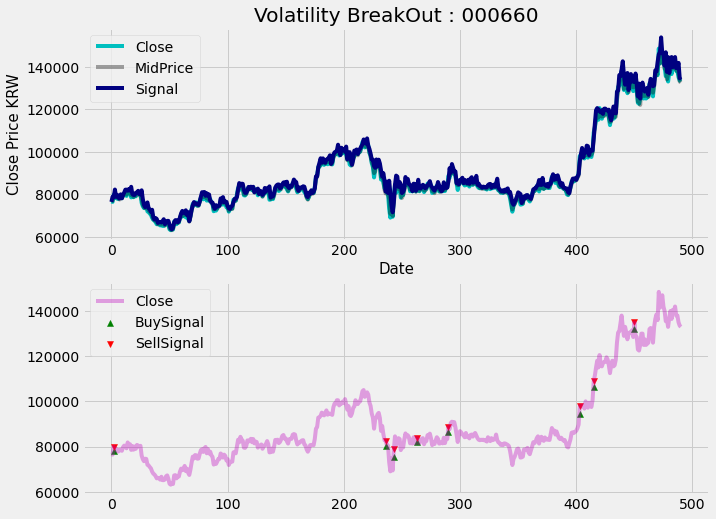

,CumulativeReturn,HitRatio,BestReturn,WorstReturn,MDD,SimpleMean,GeoMean,#Trade,SharpeRatio
000660,1.25,1,0.04,0.02,0.34,1.03,1.03,8,3.06


In [156]:
VB_Run('2019-04-01', '2021-03-25', '000660',0.5, 0.02, True)

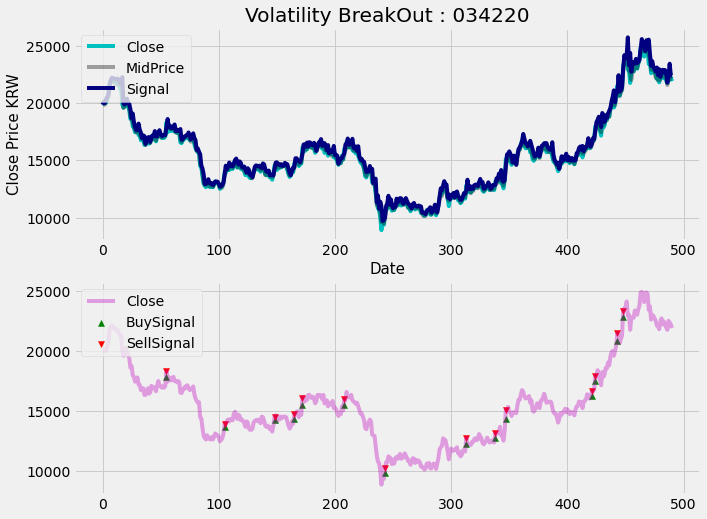

,CumulativeReturn,HitRatio,BestReturn,WorstReturn,MDD,SimpleMean,GeoMean,#Trade,SharpeRatio
034220,1.52,1,0.05,0.02,0.6,1.03,1.03,14,4.49


In [164]:
VB_Run('2019-04-01', '2021-03-25', '034220',0.5, 0.02, True)

In [157]:
%%time
total = pd.DataFrame()
start = '2016-04-01'
end = '2021-03-23'
for cd in ['005930','005935','034220','066570']:
    total = pd.concat([total,VB_Run(start, end, cd,0.5,0.02,False)])

Wall time: 14.9 s


In [158]:
total

,CumulativeReturn,HitRatio,BestReturn,WorstReturn,MDD,SimpleMean,GeoMean,#Trade,SharpeRatio
005930,1.17,1,0.04,0.02,0.32,1.03,1.03,6,1.81
005935,1.27,1,0.04,0.02,0.33,1.03,1.03,9,4.18
034220,2.39,1,0.05,0.02,0.77,1.03,1.03,32,5.98
066570,2.26,1,0.13,0.02,0.63,1.03,1.03,25,2.85


In [159]:
%%time
total = pd.DataFrame()
start = '2019-04-01'
end = '2021-03-23'
for cd in ['005930','005935','034220','066570']:
    total = pd.concat([total,VB_Run(start, end, cd,0.5,0.02,False)])

Wall time: 5.94 s


In [160]:
total

,CumulativeReturn,HitRatio,BestReturn,WorstReturn,MDD,SimpleMean,GeoMean,#Trade,SharpeRatio
005930,1.14,1,0.04,0.02,0.32,1.03,1.03,5,1.75
005935,1.09,1,0.04,0.02,0.33,1.03,1.03,3,2.07
034220,1.52,1,0.05,0.02,0.6,1.03,1.03,14,4.49
066570,1.54,1,0.13,0.02,0.23,1.04,1.04,11,1.98


# Conclusion
* Since this strategy is not a overnight trade and gives us a long position when a extremely short-term trend occur, HitRatio and the number of trades are high.
* Even though the BestReturn would not be high compared to other indicators, accumulated small positive returns make this portfolio's SharpeRatio high.
* But this small cap is assured when a stock is volatile. Otherwise, slippage could be fatal.
* In conclusion, this is not a 'indicator' but 'strategy' so we can use it by combining other indicators (like trend-momentum, reversals and so on).

---